<a href="https://colab.research.google.com/github/Mohamadaminlotfi98/Spike-time-prediction-from-LFP-signals/blob/main/spike_Detection_from_LFP_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/MyDrive

In [ ]:
!unzip your_zip_file.zip -d destination_folder

In [ ]:
!ls

 22G		    LFP_SPIKE	     SortingDeep.docx
'Colab Notebooks'   nwb_api-python  'Untitled Diagram.drawio.png'


In [ ]:
!pip install pymatreader

In [ ]:
from pymatreader import read_mat
data = read_mat('LFP_SPIKE/l101210-001_raw-lfp-spikes_ch96.mat')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.fft as fft
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm


In [ ]:
data['block']['segments']['spiketrains']

[{'an_electrode_reject_LFC': 0,
  'an_connector_aligned_id': 9,
  'an_mua': 0,
  'an_electrode_reject_HFC': 0,
  'an_sua': 0,
  'file_origin': '../datasets/l101210-001-02.nev',
  'an_electrode_reject_IFC': 0,
  'waveforms': array([[-16., -15., -15., ...,  14.,  19.,  26.],
         [  9.,   7.,   0., ..., -36., -34., -25.],
         [-11., -14., -29., ...,   3.,   9.,  15.],
         ...,
         [-15., -13.,  -5., ..., -12., -16., -13.],
         [-18., -15., -17., ...,   3.,  -3.,  -8.],
         [ -1.,  -4.,   2., ...,   7.,  -3., -11.]]),
  't_stop': 21277439.0,
  'sampling_rate': 30000.0,
  'description': 'SpikeTrain from channel: 96, unit: unclassified',
  't_stop_units': '(1.0/30000 * s)',
  't_start': 0.0,
  'an_noise': 1,
  'left_sweep': 10.0,
  'waveforms_units': 'uV',
  'times_units': '(1.0/30000 * s)',
  'sampling_rate_units': 'Hz',
  'name': 'Unit 96000',
  't_start_units': '(1.0/30000 * s)',
  'times': array([   71586.,    74163.,    74693.,   187139.,   190272.,   19090

In [ ]:
lfp = data['block']['segments']['analogsignals']['signal']
spike_time = data['block']['segments']['spiketrains'][1]['times']
spike_waveform = data['block']['segments']['spiketrains'][1]['waveforms']
sampling_rate = 30000
print(lfp.shape)
print(spike_time.shape)
print(spike_waveform.shape)

(21277439,)
(8413,)
(8413, 48)


In [ ]:
from scipy.signal import resample

window_size = 80
# Plot first 10 spike waveforms with corresponding LFP
for i in range(10):
    # Create a new figure and axes
    fig, ax = plt.subplots(figsize=(12,6))
    # Find the index of the spike time in the LFP signal
    spike_index = int(spike_time[i])
    # Extract the LFP signal in a window around the spike
    window_start = spike_index - int(window_size / 2)
    window_end = spike_index + int(window_size / 2)
    window_lfp = lfp[window_start:window_end]
    window_time = time[window_start:window_end]
    # Resample the spike waveform to match the sample rate of the LFP signal
    resampled_spike_waveform = resample(spike_waveform[i], window_size)
    # Plot the LFP signal and spike waveform
    ax.plot(window_time, window_lfp, color='gray', linewidth=1)
    ax.plot(window_time[:len(spike_waveform[i])], spike_waveform[i], color='red', linewidth=2)
    # Plot a line at the level of the resampled spike waveform
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('LFP')
    ax.set_title(f'Spike Waveform {i+1} with Corresponding LFP')
    plt.show()

In [ ]:
# from scipy import signal
# def apply_high_pass_filter(input_signal, cutoff_frequency, sampling_frequency):
#     nyquist_frequency = 0.5 * sampling_frequency
#     normalized_cutoff = cutoff_frequency / nyquist_frequency
#     b, a = signal.butter(4, normalized_cutoff, btype='highpass', analog=True)
#     filtered_signal = signal.filtfilt(b, a, input_signal)
#     return filtered_signal
# # Example usage
# filtered_LFP = apply_high_pass_filter(lfp, cutoff_frequency=200, sampling_frequency=1000)

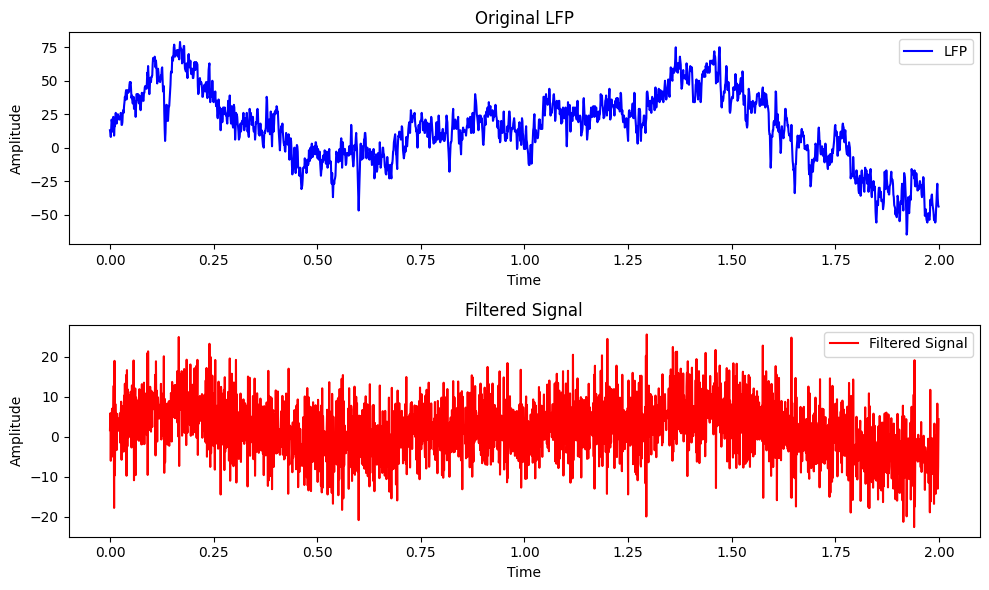

In [ ]:
# Plot the original LFP and the filtered signal
time = np.arange(len(lfp)) / 1000
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(time[:2000], lfp[:2000], 'b-', label='LFP')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Original LFP')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(time[:2000], filtered_LFP[:2000], 'r-', label='Filtered Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Filtered Signal')
plt.legend()
plt.tight_layout()
plt.show()

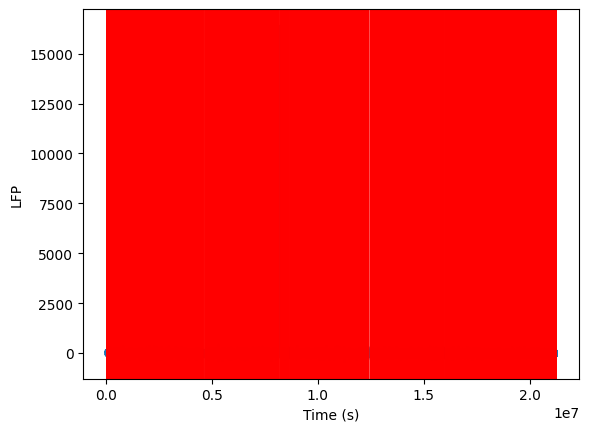

In [ ]:
time_axis = np.arange(lfp.shape[0])
fig, ax = plt.subplots()
ax.plot(time_axis, lfp)
for t in spike_time:
    ax.axvline(x=t, color='red', linewidth=0.5)
ax.set_ylabel('LFP')
ax.set_xlabel('Time (s)')
plt.show()

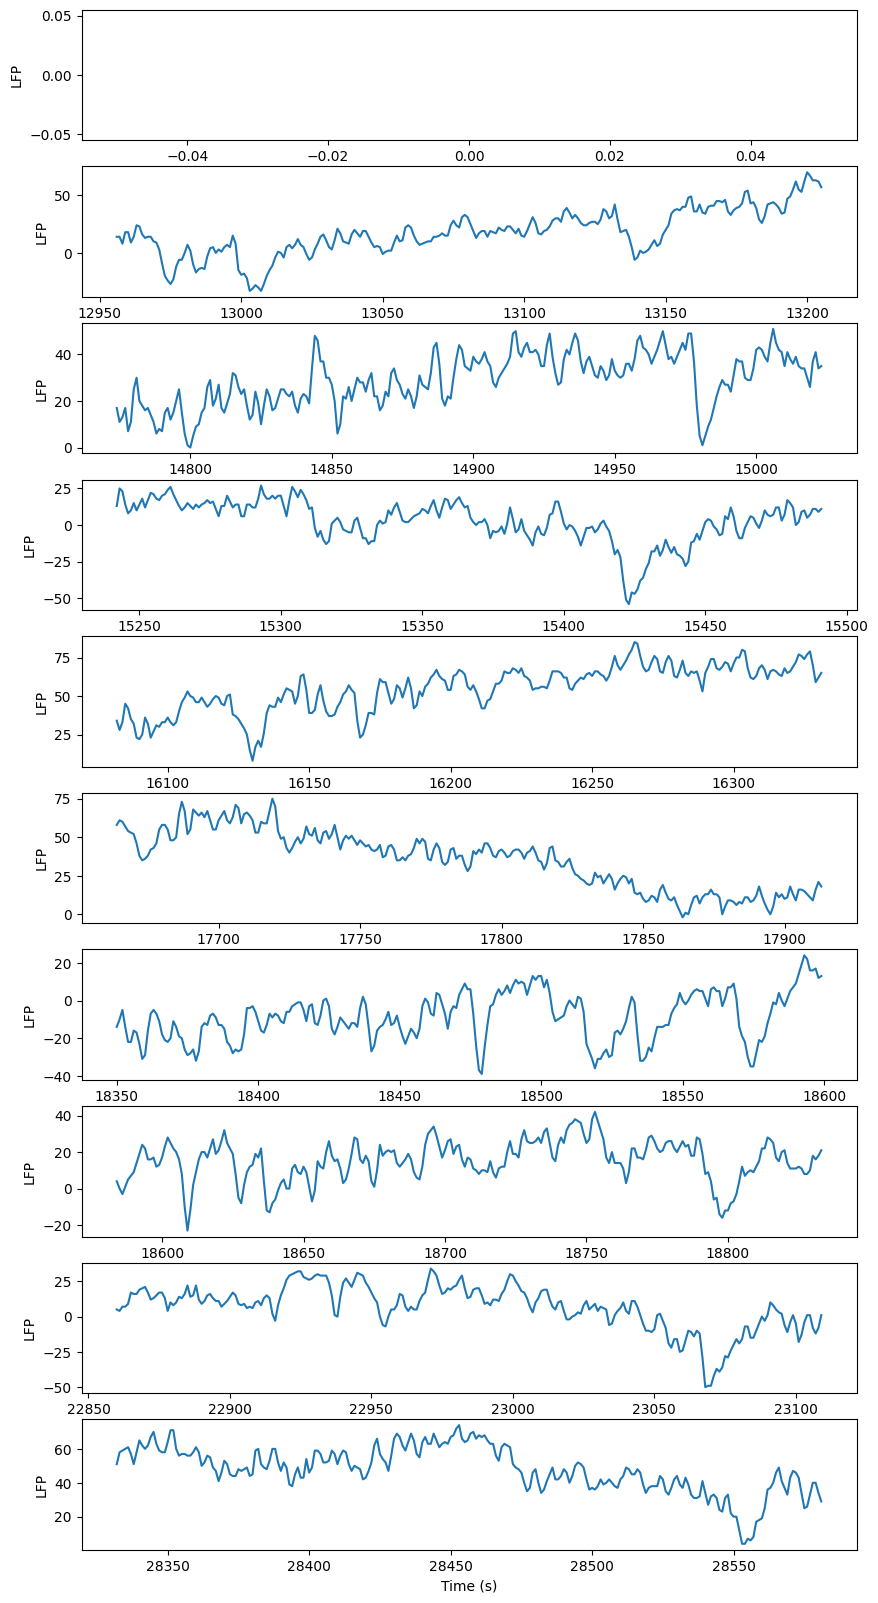

In [ ]:
window_size = 250
time_axis = np.arange(lfp.shape[0])
fig, axs = plt.subplots(10, 1, figsize=(10, 20))
for i, t in enumerate(spike_time[:10]):
    start_index = int(t - window_size)
    end_index = int(t)
    axs[i].plot(time_axis[start_index:end_index], lfp[start_index:end_index])
    axs[i].set_ylabel('LFP')
axs[-1].set_xlabel('Time (s)')
plt.show()

In [ ]:
# window_size = 50  # define the window size in number of samples
# windows_split = []
# labels = []
# spike_times = spike_time.astype(int)

# # Check if the first spike time is smaller than the window size
# if spike_times[0] < window_size:
#     window_no_spike = lfp[:window_size]
#     label_no_spike = 1
#     windows_split.append(window_no_spike)
#     labels.append(label_no_spike)

# # Iterate over the spike times
# for i, t in enumerate(spike_times):
#     if t - window_size < 0 or t + window_size + 1 >= len(lfp):
#         continue
#     window_spike = lfp[t - window_size:t]
#     label_spike = 1
#     windows_split.append(window_spike)
#     labels.append(label_spike)
#     window_no_spike = lfp[t + 1:t + window_size + 1]
#     label_no_spike = 0
#     windows_split.append(window_no_spike)
#     labels.append(label_no_spike)
# windows = np.array(windows_split)
# labels = np.array(labels)

In [ ]:
window_size = 200
step_size = 1
deviation = 5
spk_time = list(spike_time)
lfp_windows = []
lbls = []
i = 0
while i + window_size <= len(lfp):
    contains_spike = False
    window_start = i
    window_end = i + window_size
    window = lfp[i:i + window_size]
    lfp_windows.append(window)
    i += step_size
    if spk_time[1] - deviation <= window_end <= spk_time[1]:
        contains_spike = True
        if window_end == spk_time[1]:
            spk_time.pop(1)
    lbls.append(1 if contains_spike else 0)
lfp_windows = torch.tensor(np.array(lfp_windows))
labels = torch.tensor(np.array(lbls))

IndexError: ignored

In [ ]:
lfp_windows.shape

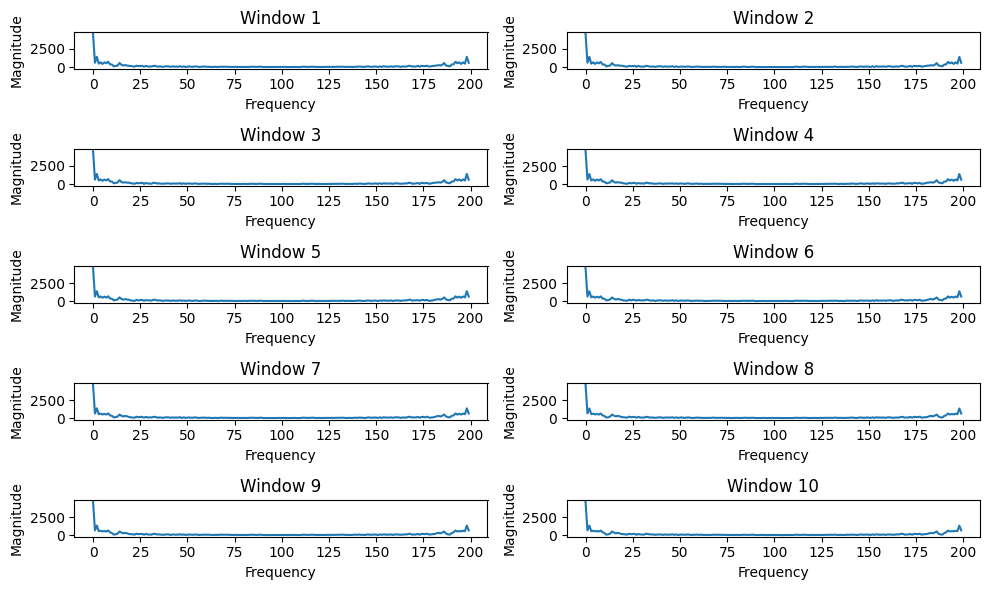

In [ ]:
windows_subset =lfp_windows[:10]
fft_windows = np.fft.fft(windows_subset)
fft_magnitudes = np.abs(fft_windows)
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.plot(fft_magnitudes[i])
    plt.title(f'Window {i+1}')
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()


In [ ]:
class TransformerFeatureExtractor(nn.Module):
    def __init__(self, input_size):
        super(TransformerFeatureExtractor, self).__init__()
        self.input_size = input_size
        self.transformer_encoder1 = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_size, nhead=50, dim_feedforward=256),
            num_layers=3)
        self.transformer_encoder2 = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_size, nhead=50, dim_feedforward=256),
            num_layers=3)
        self.fc = nn.Linear( input_size , 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        encoded = self.transformer_encoder1(x)
        encoded = self.transformer_encoder2(encoded)
        features = self.fc(encoded)
        probabilities = self.softmax(features)
        return probabilities


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#windows_tensor = torch.as_tensor(lfp_windows, dtype=torch.float32).clone().detach().to(device)
#labels_tensor = torch.as_tensor(labels, dtype=torch.long).clone().detach().to(device)
#train_windows, test_windows, train_labels, test_labels = train_test_split(windows_tensor, labels_tensor, test_size=0.2, random_state=42 , shuffle = False)
model = TransformerFeatureExtractor(input_size=window_size).to(device)

In [ ]:
# x = torch.rand(32,200)
# print(model(x))

In [ ]:
batch_size = 32
test_batch_size = 32
split_index = int(0.8 * len(windows))
train_data = torch.tensor(windows[:split_index])  # Convert to PyTorch tensor
train_labels = torch.tensor(labels[:split_index])  # Convert to PyTorch tensor
test_data = torch.tensor(windows[split_index:])  # Convert to PyTorch tensor
test_labels = torch.tensor(labels[split_index:])  # Convert to PyTorch tensor

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

print('train:', train_data.shape)
print('test:', test_data.shape)
print('train_label:', train_labels.shape)
print('test_label:', test_labels.shape)


train: torch.Size([18718, 50])
test: torch.Size([4680, 50])
train_label: torch.Size([18718])
test_label: torch.Size([4680])


In [ ]:
train_labels_count = np.bincount(train_labels)
test_labels_count = np.bincount(test_labels)
num_classes = len(train_labels_count)  # Assuming the number of classes is the same for train and test sets
for class_id in range(num_classes):
    train_samples = train_labels_count[class_id]
    test_samples = test_labels_count[class_id]
    print(f"Class {class_id}: Train samples: {train_samples}, Test samples: {test_samples}")

Class 0: Train samples: 9359, Test samples: 2340
Class 1: Train samples: 9359, Test samples: 2340


In [ ]:
# Convert the class counts to weights
class_weights = 1.0 / torch.tensor(train_labels_count, dtype=torch.float)
# Create a weight tensor that matches the number of classes
weight_tensor = torch.zeros(num_classes)
# Assign the class weights to the appropriate indices in the weight tensor
weight_tensor.scatter_(0, torch.tensor(range(num_classes)), class_weights)

tensor([1.2542e-06, 4.0064e-04])

In [ ]:
# Define loss function, optimizer, and other parameters
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
epochs = 100
correct = 0
# Training loop
for epoch in range(epochs):
    running_loss = 0.0
    # Initialize tqdm for the epoch
    epoch_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
    # Training loop
    for batch_idx, (batch_data, batch_labels) in epoch_progress:
        # Forward pass
        outputs = model(batch_data)
        loss = loss_function(outputs.squeeze(), batch_labels)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # Update tqdm progress bar
        epoch_progress.set_postfix({"Loss": loss.item()})
    epoch_loss = running_loss / len(train_loader)
    # Testing loop
    correct = 0
    for test_batch_data, test_batch_labels in test_loader:
        with torch.no_grad():
            test_outputs = model(test_batch_data)
            test_pred = torch.argmax(test_outputs, dim=1)
            correct += (test_pred == test_batch_labels).sum().item()
    test_acc = correct / len(test_data)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Test Accuracy: {test_acc:.4f}, True Predictions: {correct}/{len(test_data)}")


Epoch 1/100: 100%|██████████| 585/585 [00:23<00:00, 24.73batch/s, Loss=0.642]


Epoch [1/100], Loss: 0.6423, Test Accuracy: 0.7235, True Predictions: 3386/4680


Epoch 2/100: 100%|██████████| 585/585 [00:20<00:00, 28.49batch/s, Loss=0.574]


Epoch [2/100], Loss: 0.5869, Test Accuracy: 0.7989, True Predictions: 3739/4680


Epoch 3/100: 100%|██████████| 585/585 [00:22<00:00, 25.63batch/s, Loss=0.545]


Epoch [3/100], Loss: 0.5451, Test Accuracy: 0.8284, True Predictions: 3877/4680


Epoch 4/100: 100%|██████████| 585/585 [00:21<00:00, 27.37batch/s, Loss=0.524]


Epoch [4/100], Loss: 0.4984, Test Accuracy: 0.8583, True Predictions: 4017/4680


Epoch 5/100: 100%|██████████| 585/585 [00:20<00:00, 28.69batch/s, Loss=0.521]


Epoch [5/100], Loss: 0.4752, Test Accuracy: 0.8850, True Predictions: 4142/4680


Epoch 6/100: 100%|██████████| 585/585 [00:21<00:00, 26.96batch/s, Loss=0.488]


Epoch [6/100], Loss: 0.4496, Test Accuracy: 0.8962, True Predictions: 4194/4680


Epoch 7/100: 100%|██████████| 585/585 [00:20<00:00, 28.71batch/s, Loss=0.465]


Epoch [7/100], Loss: 0.4343, Test Accuracy: 0.9115, True Predictions: 4266/4680


Epoch 8/100: 100%|██████████| 585/585 [00:21<00:00, 27.09batch/s, Loss=0.48]


Epoch [8/100], Loss: 0.4146, Test Accuracy: 0.9344, True Predictions: 4373/4680


Epoch 9/100: 100%|██████████| 585/585 [00:20<00:00, 28.69batch/s, Loss=0.46]


Epoch [9/100], Loss: 0.3943, Test Accuracy: 0.9442, True Predictions: 4419/4680


Epoch 10/100: 100%|██████████| 585/585 [00:21<00:00, 27.00batch/s, Loss=0.469]


Epoch [10/100], Loss: 0.3823, Test Accuracy: 0.9468, True Predictions: 4431/4680


Epoch 11/100: 100%|██████████| 585/585 [00:20<00:00, 28.76batch/s, Loss=0.425]


Epoch [11/100], Loss: 0.3730, Test Accuracy: 0.9556, True Predictions: 4472/4680


Epoch 12/100: 100%|██████████| 585/585 [00:21<00:00, 27.02batch/s, Loss=0.408]


Epoch [12/100], Loss: 0.3664, Test Accuracy: 0.9615, True Predictions: 4500/4680


Epoch 13/100: 100%|██████████| 585/585 [00:20<00:00, 28.65batch/s, Loss=0.434]


Epoch [13/100], Loss: 0.3595, Test Accuracy: 0.9654, True Predictions: 4518/4680


Epoch 14/100: 100%|██████████| 585/585 [00:21<00:00, 26.92batch/s, Loss=0.405]


Epoch [14/100], Loss: 0.3569, Test Accuracy: 0.9673, True Predictions: 4527/4680


Epoch 15/100: 100%|██████████| 585/585 [00:20<00:00, 28.83batch/s, Loss=0.405]


Epoch [15/100], Loss: 0.3534, Test Accuracy: 0.9682, True Predictions: 4531/4680


Epoch 16/100: 100%|██████████| 585/585 [00:21<00:00, 26.82batch/s, Loss=0.409]


Epoch [16/100], Loss: 0.3509, Test Accuracy: 0.9688, True Predictions: 4534/4680


Epoch 17/100: 100%|██████████| 585/585 [00:20<00:00, 28.61batch/s, Loss=0.409]


Epoch [17/100], Loss: 0.3481, Test Accuracy: 0.9737, True Predictions: 4557/4680


Epoch 18/100: 100%|██████████| 585/585 [00:21<00:00, 26.78batch/s, Loss=0.385]


Epoch [18/100], Loss: 0.3478, Test Accuracy: 0.9761, True Predictions: 4568/4680


Epoch 19/100: 100%|██████████| 585/585 [00:20<00:00, 28.27batch/s, Loss=0.419]


Epoch [19/100], Loss: 0.3436, Test Accuracy: 0.9776, True Predictions: 4575/4680


Epoch 20/100: 100%|██████████| 585/585 [00:21<00:00, 27.43batch/s, Loss=0.393]


Epoch [20/100], Loss: 0.3432, Test Accuracy: 0.9769, True Predictions: 4572/4680


Epoch 21/100: 100%|██████████| 585/585 [00:20<00:00, 28.77batch/s, Loss=0.396]


Epoch [21/100], Loss: 0.3420, Test Accuracy: 0.9776, True Predictions: 4575/4680


Epoch 22/100: 100%|██████████| 585/585 [00:21<00:00, 27.49batch/s, Loss=0.373]


Epoch [22/100], Loss: 0.3406, Test Accuracy: 0.9744, True Predictions: 4560/4680


Epoch 23/100: 100%|██████████| 585/585 [00:20<00:00, 28.11batch/s, Loss=0.37]


Epoch [23/100], Loss: 0.3403, Test Accuracy: 0.9759, True Predictions: 4567/4680


Epoch 24/100: 100%|██████████| 585/585 [00:21<00:00, 27.75batch/s, Loss=0.386]


Epoch [24/100], Loss: 0.3384, Test Accuracy: 0.9784, True Predictions: 4579/4680


Epoch 25/100: 100%|██████████| 585/585 [00:20<00:00, 28.16batch/s, Loss=0.421]


Epoch [25/100], Loss: 0.3374, Test Accuracy: 0.9801, True Predictions: 4587/4680


Epoch 26/100: 100%|██████████| 585/585 [00:20<00:00, 28.31batch/s, Loss=0.327]


Epoch [26/100], Loss: 0.3369, Test Accuracy: 0.9771, True Predictions: 4573/4680


Epoch 27/100: 100%|██████████| 585/585 [00:21<00:00, 27.82batch/s, Loss=0.374]


Epoch [27/100], Loss: 0.3359, Test Accuracy: 0.9808, True Predictions: 4590/4680


Epoch 28/100: 100%|██████████| 585/585 [00:20<00:00, 28.62batch/s, Loss=0.389]


Epoch [28/100], Loss: 0.3348, Test Accuracy: 0.9795, True Predictions: 4584/4680


Epoch 29/100: 100%|██████████| 585/585 [00:21<00:00, 27.74batch/s, Loss=0.375]


Epoch [29/100], Loss: 0.3348, Test Accuracy: 0.9818, True Predictions: 4595/4680


Epoch 30/100: 100%|██████████| 585/585 [00:20<00:00, 28.86batch/s, Loss=0.364]


Epoch [30/100], Loss: 0.3343, Test Accuracy: 0.9825, True Predictions: 4598/4680


Epoch 31/100: 100%|██████████| 585/585 [00:21<00:00, 27.66batch/s, Loss=0.336]


Epoch [31/100], Loss: 0.3333, Test Accuracy: 0.9799, True Predictions: 4586/4680


Epoch 32/100: 100%|██████████| 585/585 [00:20<00:00, 28.86batch/s, Loss=0.349]


Epoch [32/100], Loss: 0.3333, Test Accuracy: 0.9797, True Predictions: 4585/4680


Epoch 33/100: 100%|██████████| 585/585 [00:21<00:00, 27.08batch/s, Loss=0.36]


Epoch [33/100], Loss: 0.3327, Test Accuracy: 0.9801, True Predictions: 4587/4680


Epoch 34/100: 100%|██████████| 585/585 [00:20<00:00, 28.88batch/s, Loss=0.346]


Epoch [34/100], Loss: 0.3313, Test Accuracy: 0.9795, True Predictions: 4584/4680


Epoch 35/100: 100%|██████████| 585/585 [00:21<00:00, 27.27batch/s, Loss=0.355]


Epoch [35/100], Loss: 0.3318, Test Accuracy: 0.9808, True Predictions: 4590/4680


Epoch 36/100: 100%|██████████| 585/585 [00:20<00:00, 28.69batch/s, Loss=0.332]


Epoch [36/100], Loss: 0.3313, Test Accuracy: 0.9812, True Predictions: 4592/4680


Epoch 37/100: 100%|██████████| 585/585 [00:21<00:00, 26.89batch/s, Loss=0.373]


Epoch [37/100], Loss: 0.3313, Test Accuracy: 0.9812, True Predictions: 4592/4680


Epoch 38/100: 100%|██████████| 585/585 [00:20<00:00, 28.61batch/s, Loss=0.359]


Epoch [38/100], Loss: 0.3307, Test Accuracy: 0.9821, True Predictions: 4596/4680


Epoch 39/100: 100%|██████████| 585/585 [00:21<00:00, 26.89batch/s, Loss=0.337]


Epoch [39/100], Loss: 0.3306, Test Accuracy: 0.9814, True Predictions: 4593/4680


Epoch 40/100: 100%|██████████| 585/585 [00:20<00:00, 28.79batch/s, Loss=0.358]


Epoch [40/100], Loss: 0.3304, Test Accuracy: 0.9821, True Predictions: 4596/4680


Epoch 41/100: 100%|██████████| 585/585 [00:21<00:00, 26.63batch/s, Loss=0.354]


Epoch [41/100], Loss: 0.3300, Test Accuracy: 0.9855, True Predictions: 4612/4680


Epoch 42/100: 100%|██████████| 585/585 [00:20<00:00, 28.72batch/s, Loss=0.355]


Epoch [42/100], Loss: 0.3302, Test Accuracy: 0.9801, True Predictions: 4587/4680


Epoch 43/100: 100%|██████████| 585/585 [00:21<00:00, 26.80batch/s, Loss=0.387]


Epoch [43/100], Loss: 0.3296, Test Accuracy: 0.9859, True Predictions: 4614/4680


Epoch 44/100: 100%|██████████| 585/585 [00:20<00:00, 28.61batch/s, Loss=0.361]


Epoch [44/100], Loss: 0.3304, Test Accuracy: 0.9835, True Predictions: 4603/4680


Epoch 45/100: 100%|██████████| 585/585 [00:21<00:00, 26.77batch/s, Loss=0.387]


Epoch [45/100], Loss: 0.3296, Test Accuracy: 0.9827, True Predictions: 4599/4680


Epoch 46/100: 100%|██████████| 585/585 [00:20<00:00, 28.80batch/s, Loss=0.368]


Epoch [46/100], Loss: 0.3291, Test Accuracy: 0.9846, True Predictions: 4608/4680


Epoch 47/100: 100%|██████████| 585/585 [00:21<00:00, 27.01batch/s, Loss=0.366]


Epoch [47/100], Loss: 0.3295, Test Accuracy: 0.9844, True Predictions: 4607/4680


Epoch 48/100: 100%|██████████| 585/585 [00:20<00:00, 28.87batch/s, Loss=0.374]


Epoch [48/100], Loss: 0.3288, Test Accuracy: 0.9833, True Predictions: 4602/4680


Epoch 49/100: 100%|██████████| 585/585 [00:21<00:00, 26.80batch/s, Loss=0.341]


Epoch [49/100], Loss: 0.3277, Test Accuracy: 0.9850, True Predictions: 4610/4680


Epoch 50/100: 100%|██████████| 585/585 [00:20<00:00, 28.62batch/s, Loss=0.363]


Epoch [50/100], Loss: 0.3278, Test Accuracy: 0.9825, True Predictions: 4598/4680


Epoch 51/100: 100%|██████████| 585/585 [00:21<00:00, 26.66batch/s, Loss=0.372]


Epoch [51/100], Loss: 0.3281, Test Accuracy: 0.9846, True Predictions: 4608/4680


Epoch 52/100: 100%|██████████| 585/585 [00:20<00:00, 28.24batch/s, Loss=0.353]


Epoch [52/100], Loss: 0.3274, Test Accuracy: 0.9846, True Predictions: 4608/4680


Epoch 53/100: 100%|██████████| 585/585 [00:21<00:00, 27.30batch/s, Loss=0.321]


Epoch [53/100], Loss: 0.3275, Test Accuracy: 0.9857, True Predictions: 4613/4680


Epoch 54/100: 100%|██████████| 585/585 [00:20<00:00, 28.86batch/s, Loss=0.349]


Epoch [54/100], Loss: 0.3271, Test Accuracy: 0.9865, True Predictions: 4617/4680


Epoch 55/100: 100%|██████████| 585/585 [00:21<00:00, 27.26batch/s, Loss=0.372]


Epoch [55/100], Loss: 0.3277, Test Accuracy: 0.9835, True Predictions: 4603/4680


Epoch 56/100: 100%|██████████| 585/585 [00:20<00:00, 28.46batch/s, Loss=0.365]


Epoch [56/100], Loss: 0.3273, Test Accuracy: 0.9850, True Predictions: 4610/4680


Epoch 57/100: 100%|██████████| 585/585 [00:21<00:00, 27.65batch/s, Loss=0.391]


Epoch [57/100], Loss: 0.3272, Test Accuracy: 0.9848, True Predictions: 4609/4680


Epoch 58/100: 100%|██████████| 585/585 [00:20<00:00, 28.49batch/s, Loss=0.369]


Epoch [58/100], Loss: 0.3268, Test Accuracy: 0.9868, True Predictions: 4618/4680


Epoch 59/100: 100%|██████████| 585/585 [00:20<00:00, 27.91batch/s, Loss=0.335]


Epoch [59/100], Loss: 0.3259, Test Accuracy: 0.9848, True Predictions: 4609/4680


Epoch 60/100: 100%|██████████| 585/585 [00:20<00:00, 28.45batch/s, Loss=0.34]


Epoch [60/100], Loss: 0.3259, Test Accuracy: 0.9846, True Predictions: 4608/4680


Epoch 61/100: 100%|██████████| 585/585 [00:20<00:00, 27.96batch/s, Loss=0.33]


Epoch [61/100], Loss: 0.3262, Test Accuracy: 0.9846, True Predictions: 4608/4680


Epoch 62/100: 100%|██████████| 585/585 [00:20<00:00, 28.53batch/s, Loss=0.351]


Epoch [62/100], Loss: 0.3258, Test Accuracy: 0.9846, True Predictions: 4608/4680


Epoch 63/100: 100%|██████████| 585/585 [00:21<00:00, 27.81batch/s, Loss=0.349]


Epoch [63/100], Loss: 0.3264, Test Accuracy: 0.9865, True Predictions: 4617/4680


Epoch 64/100: 100%|██████████| 585/585 [00:20<00:00, 28.21batch/s, Loss=0.373]


Epoch [64/100], Loss: 0.3265, Test Accuracy: 0.9846, True Predictions: 4608/4680


Epoch 65/100: 100%|██████████| 585/585 [00:20<00:00, 27.94batch/s, Loss=0.338]


Epoch [65/100], Loss: 0.3258, Test Accuracy: 0.9840, True Predictions: 4605/4680


Epoch 66/100: 100%|██████████| 585/585 [00:20<00:00, 28.16batch/s, Loss=0.341]


Epoch [66/100], Loss: 0.3258, Test Accuracy: 0.9870, True Predictions: 4619/4680


Epoch 67/100: 100%|██████████| 585/585 [00:20<00:00, 28.15batch/s, Loss=0.358]


Epoch [67/100], Loss: 0.3256, Test Accuracy: 0.9844, True Predictions: 4607/4680


Epoch 68/100: 100%|██████████| 585/585 [00:20<00:00, 28.03batch/s, Loss=0.398]


Epoch [68/100], Loss: 0.3257, Test Accuracy: 0.9859, True Predictions: 4614/4680


Epoch 69/100: 100%|██████████| 585/585 [00:20<00:00, 28.40batch/s, Loss=0.326]


Epoch [69/100], Loss: 0.3255, Test Accuracy: 0.9857, True Predictions: 4613/4680


Epoch 70/100: 100%|██████████| 585/585 [00:20<00:00, 28.23batch/s, Loss=0.321]


Epoch [70/100], Loss: 0.3256, Test Accuracy: 0.9874, True Predictions: 4621/4680


Epoch 71/100: 100%|██████████| 585/585 [00:20<00:00, 28.09batch/s, Loss=0.323]


Epoch [71/100], Loss: 0.3253, Test Accuracy: 0.9870, True Predictions: 4619/4680


Epoch 72/100: 100%|██████████| 585/585 [00:21<00:00, 27.48batch/s, Loss=0.323]


Epoch [72/100], Loss: 0.3255, Test Accuracy: 0.9876, True Predictions: 4622/4680


Epoch 73/100: 100%|██████████| 585/585 [00:20<00:00, 27.95batch/s, Loss=0.333]


Epoch [73/100], Loss: 0.3251, Test Accuracy: 0.9831, True Predictions: 4601/4680


Epoch 74/100: 100%|██████████| 585/585 [00:21<00:00, 27.31batch/s, Loss=0.315]


Epoch [74/100], Loss: 0.3249, Test Accuracy: 0.9874, True Predictions: 4621/4680


Epoch 75/100: 100%|██████████| 585/585 [00:20<00:00, 28.34batch/s, Loss=0.317]


Epoch [75/100], Loss: 0.3252, Test Accuracy: 0.9872, True Predictions: 4620/4680


Epoch 76/100: 100%|██████████| 585/585 [00:21<00:00, 26.91batch/s, Loss=0.364]


Epoch [76/100], Loss: 0.3248, Test Accuracy: 0.9874, True Predictions: 4621/4680


Epoch 77/100: 100%|██████████| 585/585 [00:20<00:00, 28.14batch/s, Loss=0.349]


Epoch [77/100], Loss: 0.3251, Test Accuracy: 0.9885, True Predictions: 4626/4680


Epoch 78/100: 100%|██████████| 585/585 [00:22<00:00, 26.29batch/s, Loss=0.367]


Epoch [78/100], Loss: 0.3247, Test Accuracy: 0.9868, True Predictions: 4618/4680


Epoch 79/100: 100%|██████████| 585/585 [00:20<00:00, 28.22batch/s, Loss=0.336]


Epoch [79/100], Loss: 0.3238, Test Accuracy: 0.9865, True Predictions: 4617/4680


Epoch 80/100: 100%|██████████| 585/585 [00:22<00:00, 26.42batch/s, Loss=0.35]


Epoch [80/100], Loss: 0.3244, Test Accuracy: 0.9878, True Predictions: 4623/4680


Epoch 81/100: 100%|██████████| 585/585 [00:20<00:00, 28.28batch/s, Loss=0.335]


Epoch [81/100], Loss: 0.3246, Test Accuracy: 0.9870, True Predictions: 4619/4680


Epoch 82/100: 100%|██████████| 585/585 [00:22<00:00, 26.33batch/s, Loss=0.314]


Epoch [82/100], Loss: 0.3243, Test Accuracy: 0.9885, True Predictions: 4626/4680


Epoch 83/100: 100%|██████████| 585/585 [00:20<00:00, 28.17batch/s, Loss=0.344]


Epoch [83/100], Loss: 0.3242, Test Accuracy: 0.9878, True Predictions: 4623/4680


Epoch 84/100: 100%|██████████| 585/585 [00:22<00:00, 26.36batch/s, Loss=0.339]


Epoch [84/100], Loss: 0.3237, Test Accuracy: 0.9863, True Predictions: 4616/4680


Epoch 85/100: 100%|██████████| 585/585 [00:20<00:00, 28.34batch/s, Loss=0.32]


Epoch [85/100], Loss: 0.3243, Test Accuracy: 0.9868, True Predictions: 4618/4680


Epoch 86/100: 100%|██████████| 585/585 [00:22<00:00, 26.23batch/s, Loss=0.342]


Epoch [86/100], Loss: 0.3236, Test Accuracy: 0.9874, True Predictions: 4621/4680


Epoch 87/100: 100%|██████████| 585/585 [00:20<00:00, 28.11batch/s, Loss=0.334]


Epoch [87/100], Loss: 0.3234, Test Accuracy: 0.9872, True Predictions: 4620/4680


Epoch 88/100: 100%|██████████| 585/585 [00:21<00:00, 26.72batch/s, Loss=0.327]


Epoch [88/100], Loss: 0.3239, Test Accuracy: 0.9874, True Predictions: 4621/4680


Epoch 89/100: 100%|██████████| 585/585 [00:20<00:00, 28.18batch/s, Loss=0.333]


Epoch [89/100], Loss: 0.3241, Test Accuracy: 0.9876, True Predictions: 4622/4680


Epoch 90/100: 100%|██████████| 585/585 [00:21<00:00, 27.18batch/s, Loss=0.371]


Epoch [90/100], Loss: 0.3239, Test Accuracy: 0.9865, True Predictions: 4617/4680


Epoch 91/100: 100%|██████████| 585/585 [00:27<00:00, 20.98batch/s, Loss=0.369]


Epoch [91/100], Loss: 0.3241, Test Accuracy: 0.9872, True Predictions: 4620/4680


Epoch 92/100: 100%|██████████| 585/585 [00:24<00:00, 23.78batch/s, Loss=0.344]


Epoch [92/100], Loss: 0.3237, Test Accuracy: 0.9870, True Predictions: 4619/4680


Epoch 93/100: 100%|██████████| 585/585 [00:20<00:00, 28.27batch/s, Loss=0.322]


Epoch [93/100], Loss: 0.3232, Test Accuracy: 0.9870, True Predictions: 4619/4680


Epoch 94/100: 100%|██████████| 585/585 [00:25<00:00, 23.33batch/s, Loss=0.365]


Epoch [94/100], Loss: 0.3234, Test Accuracy: 0.9889, True Predictions: 4628/4680


Epoch 95/100: 100%|██████████| 585/585 [00:24<00:00, 24.01batch/s, Loss=0.315]


Epoch [95/100], Loss: 0.3231, Test Accuracy: 0.9868, True Predictions: 4618/4680


Epoch 96/100: 100%|██████████| 585/585 [00:21<00:00, 27.08batch/s, Loss=0.367]


Epoch [96/100], Loss: 0.3234, Test Accuracy: 0.9878, True Predictions: 4623/4680


Epoch 97/100: 100%|██████████| 585/585 [00:22<00:00, 26.40batch/s, Loss=0.35]


Epoch [97/100], Loss: 0.3227, Test Accuracy: 0.9882, True Predictions: 4625/4680


Epoch 98/100: 100%|██████████| 585/585 [00:21<00:00, 26.68batch/s, Loss=0.351]


Epoch [98/100], Loss: 0.3233, Test Accuracy: 0.9874, True Predictions: 4621/4680


Epoch 99/100: 100%|██████████| 585/585 [00:21<00:00, 27.60batch/s, Loss=0.362]


Epoch [99/100], Loss: 0.3233, Test Accuracy: 0.9880, True Predictions: 4624/4680


Epoch 100/100: 100%|██████████| 585/585 [00:21<00:00, 27.10batch/s, Loss=0.316]


Epoch [100/100], Loss: 0.3238, Test Accuracy: 0.9865, True Predictions: 4617/4680


In [ ]:
#torch.save(model.state_dict(), 'LFP_SPIKE/weight.pt')
#model.load_state_dict(torch.load('LFP_SPIKE/weight.pt'))

In [ ]:
window_size = 200
step_size = 1
deviation = 5
spk_time = list(spike_time)
lfp_windows = []
lbls = []
i = 0
while i + window_size <= len(lfp):
    contains_spike = False
    window_start = i
    window_end = i + window_size
    window = lfp[i:i + window_size]
    lfp_windows.append(window)
    i += step_size
    if spk_time[1] - deviation <= window_end <= spk_time[1]:
        contains_spike = True
        if window_end == spk_time[1]:
            spk_time.pop(1)
    lbls.append(1 if contains_spike else 0)
lfp_windows = torch.tensor(np.array(lfp_windows))
labels = torch.tensor(np.array(lbls))

In [ ]:
lfp_windows.shape

In [ ]:
batch_size = 64  # Example batch size, adjust as needed
total_samples = len(lfp_windows)
num_batches = (total_samples - 1) // batch_size + 1
correct = 0
total = 0
# Iterate over batches
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, total_samples)
    batch_inputs = lfp_windows[start_idx:end_idx]
    batch_labels = labels[start_idx:end_idx]
    # Forward pass
    batch_outputs = model(batch_inputs)
    batch_pred = torch.argmax(batch_outputs, dim=1)
    # Update counts
    correct += (batch_pred == batch_labels).sum().item()
    total += len(batch_labels)
accuracy = correct / total * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 10.19%


In [ ]:
x = (model.transformer_encoder(lfp_windows[100:101]))

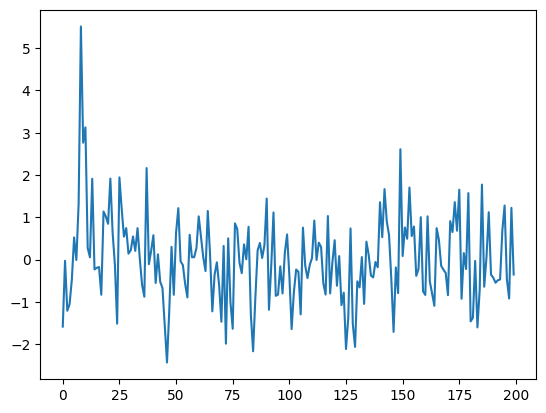

In [ ]:
plt.plot(x[0].detach().numpy())
plt.show()

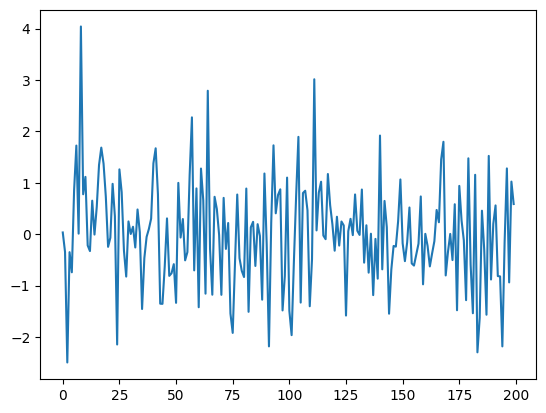

In [ ]:
plt.plot(x[0].detach().numpy())
plt.show()